## 📦 1. Importar Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 📊 2. Cargar Datos

In [3]:
# Cargar dataset
train_df = pd.read_csv('train.csv', sep=';')
test_df = pd.read_csv('test.csv', sep=';')

print(f"📌 Train shape: {train_df.shape}")
print(f"📌 Test shape: {test_df.shape}")
print(f"\n🔹 Productos únicos en train: {train_df['ID'].nunique()}")
print(f"🔹 Productos únicos en test: {test_df['ID'].nunique()}")
print(f"\n🔹 Temporadas en train: {sorted(train_df['id_season'].unique())}")
print(f"🔹 Temporadas en test: {sorted(test_df['id_season'].unique())}")

📌 Train shape: (95339, 33)
📌 Test shape: (2250, 33)

🔹 Productos únicos en train: 9843
🔹 Productos únicos en test: 2250

🔹 Temporadas en train: [np.int64(86), np.int64(87), np.int64(88), np.int64(89)]
🔹 Temporadas en test: [np.int64(90)]


## 🔍 3. Análisis de Valores Nulos (Pre-limpieza)

In [4]:
# Análisis de valores nulos
null_analysis = pd.DataFrame({
    'columna': train_df.columns,
    'valores_nulos': train_df.isnull().sum().values,
    'porcentaje_nulos': (train_df.isnull().sum() / len(train_df) * 100).values
}).sort_values('porcentaje_nulos', ascending=False)

print("🔴 Columnas con valores nulos:")
print(null_analysis[null_analysis['porcentaje_nulos'] > 0])

🔴 Columnas con valores nulos:
               columna  valores_nulos  porcentaje_nulos
14     heel_shape_type          95339        100.000000
15         toecap_type          95339        100.000000
17      knit_structure          78413         82.246510
11          waist_type          72087         75.611240
19           archetype          39732         41.674446
13  sleeve_length_type          38003         39.860917
12     neck_lapel_type          36465         38.247727
16     woven_structure          32829         34.433967
10     silhouette_type          12367         12.971607
9          length_type           8509          8.924994
18          print_type            100          0.104889


## 🧼 4. Limpieza de Datos - MEJORES PRÁCTICAS

### Estrategia Inteligente:

1. **heel_shape_type, toecap_type** (100% nulos) → ❌ **ELIMINAR**

2. **print_type** (0.1% nulos) → Rellenar con "Sin Estampado"

3. **length_type** (8.9% nulos) → Imputar según **familia**:
   - Jeans/Pantalones → "Long"
   - Skirts/Shorts → "Short"
   - Resto → "Standard"

4. **silhouette_type** (13% nulos) → Por familia:
   - Jeans → "Slim"
   - Sweaters/Coats → "Regular"
   - Resto → "Straight"

5. **waist_type** (75.6% nulos) → **CONTEXTUAL**:
   - Solo relevante para Bottoms (Jeans, Skirts, Trousers)
   - Bottoms nulos → "Regular Waist"
   - Resto → "Not Applicable"

6. **neck_lapel_type** (38% nulos) → **CONTEXTUAL**:
   - Solo para Tops/Dresses
   - Tops nulos → "Rounded Neck"
   - Bottoms → "Not Applicable"

7. **sleeve_length_type** (39.9% nulos) → **CONTEXTUAL**:
   - Solo para Tops
   - Tops nulos → "Long"
   - Bottoms → "Not Applicable"

8. **woven_structure** (34.4% nulos) → **Por fabric**:
   - Solo WOVEN → "Light"
   - Resto → "Not Applicable"

9. **knit_structure** (82.2% nulos) → **Por fabric**:
   - Solo TRICOT/CIRCULAR → "Fine point"
   - Resto → "Not Applicable"

10. **archetype** (41.7% nulos) → Imputar con **moda por familia**, fallback "Lady"

In [15]:
def clean_dataset(df, is_train=True):
    """
    Limpia y prepara el dataset con MEJORES PRÁCTICAS de imputación contextual
    """
    df_clean = df.copy()
    
    print("🔧 Iniciando limpieza con mejores prácticas...")
    print(f"   Shape inicial: {df_clean.shape}\n")
    
    # 1. ELIMINAR COLUMNAS 100% NULAS
    cols_to_drop = [col for col in df_clean.columns if df_clean[col].isnull().sum() == len(df_clean)]
    if cols_to_drop:
        df_clean = df_clean.drop(columns=cols_to_drop)
        print(f"   ❌ Eliminadas columnas 100% nulas: {cols_to_drop}\n")
    
    # 2. PROCESAR FECHAS - Features temporales avanzadas
    print("   📅 Procesando fechas...")
    df_clean['phase_in'] = pd.to_datetime(df_clean['phase_in'], format='%d/%m/%Y')
    df_clean['phase_out'] = pd.to_datetime(df_clean['phase_out'], format='%d/%m/%Y')
    
    df_clean['phase_in_month'] = df_clean['phase_in'].dt.month
    df_clean['phase_in_week'] = df_clean['phase_in'].dt.isocalendar().week
    df_clean['phase_in_dayofweek'] = df_clean['phase_in'].dt.dayofweek
    df_clean['phase_in_quarter'] = df_clean['phase_in'].dt.quarter
    df_clean['phase_out_month'] = df_clean['phase_out'].dt.month
    df_clean['phase_out_week'] = df_clean['phase_out'].dt.isocalendar().week
    
    # Indicadores de temporada
    df_clean['is_winter_launch'] = df_clean['phase_in_month'].isin([11, 12, 1, 2]).astype(int)
    df_clean['is_summer_launch'] = df_clean['phase_in_month'].isin([5, 6, 7, 8]).astype(int)
    df_clean['is_spring_launch'] = df_clean['phase_in_month'].isin([3, 4, 5]).astype(int)
    df_clean['is_fall_launch'] = df_clean['phase_in_month'].isin([9, 10, 11]).astype(int)
    
    df_clean = df_clean.drop(columns=['phase_in', 'phase_out'])
    
    # 3. PROCESAR COLOR RGB + Features derivadas
    print("   🎨 Procesando colores RGB...")
    rgb_split = df_clean['color_rgb'].str.split(',', expand=True)
    df_clean['color_r'] = pd.to_numeric(rgb_split[0], errors='coerce')
    df_clean['color_g'] = pd.to_numeric(rgb_split[1], errors='coerce')
    df_clean['color_b'] = pd.to_numeric(rgb_split[2], errors='coerce')
    
    # Features derivadas de color
    df_clean['color_brightness'] = (df_clean['color_r'] + df_clean['color_g'] + df_clean['color_b']) / 3
    df_clean['color_saturation'] = (df_clean[['color_r', 'color_g', 'color_b']].max(axis=1) - 
                                     df_clean[['color_r', 'color_g', 'color_b']].min(axis=1))
    df_clean['is_grayscale'] = ((df_clean['color_r'] - df_clean['color_g']).abs() < 10).astype(int)
    df_clean['is_dark_color'] = (df_clean['color_brightness'] < 85).astype(int)
    df_clean['is_light_color'] = (df_clean['color_brightness'] > 170).astype(int)
    
    df_clean = df_clean.drop(columns=['color_rgb'])
    
    # 4. PROCESAR IMAGE EMBEDDINGS
    print("   🖼️  Procesando image embeddings (512 dim)...")
    embeddings = df_clean['image_embedding'].str.split(',', expand=True)
    embeddings = embeddings.apply(pd.to_numeric, errors='coerce')
    embeddings.columns = [f'emb_{i}' for i in range(len(embeddings.columns))]
    
    df_clean = pd.concat([df_clean, embeddings], axis=1)
    df_clean = df_clean.drop(columns=['image_embedding'])
    
    # 5. IMPUTACIÓN INTELIGENTE BASADA EN CONTEXTO
    print("   🎯 Aplicando imputación contextual inteligente...\n")
    
    # 5.1 print_type: 0.1% nulos
    if 'print_type' in df_clean.columns:
        df_clean['print_type'] = df_clean['print_type'].fillna('Sin Estampado')
        print("      ✓ print_type: rellenado con 'Sin Estampado'")
    
    # 5.2 length_type: Imputar según familia
    if 'length_type' in df_clean.columns:
        length_mapping = {
            'Dresses and jumpsuits': 'Standard',
            'Shirts': 'Standard',
            'Jeans': 'Long',
            'Sweaters and Cardigans': 'Standard',
            'Coats and Parkas': 'Long',
            'Skirts and shorts': 'Short',
            'Jackets and Blazers': 'Standard',
            'Trousers & leggings': 'Long',
            'T-shirts': 'Standard',
            'Tops': 'Standard'
        }
        for family, default in length_mapping.items():
            mask = (df_clean['aggregated_family'] == family) & (df_clean['length_type'].isnull())
            df_clean.loc[mask, 'length_type'] = default
        df_clean['length_type'] = df_clean['length_type'].fillna('Standard')
        print("      ✓ length_type: imputado por familia de producto")
    
    # 5.3 silhouette_type
    if 'silhouette_type' in df_clean.columns:
        silhouette_mapping = {
            'Jeans': 'Slim', 'Sweaters and Cardigans': 'Regular',
            'Coats and Parkas': 'Regular', 'Jackets and Blazers': 'Regular'
        }
        for family, default in silhouette_mapping.items():
            mask = (df_clean['aggregated_family'] == family) & (df_clean['silhouette_type'].isnull())
            df_clean.loc[mask, 'silhouette_type'] = default
        df_clean['silhouette_type'] = df_clean['silhouette_type'].fillna('Straight')
        print("      ✓ silhouette_type: imputado por familia")
    
    # 5.4 waist_type: CONTEXTUAL - Solo para bottoms
    if 'waist_type' in df_clean.columns:
        bottom_families = ['Jeans', 'Skirts and shorts', 'Trousers & leggings']
        is_bottom = df_clean['aggregated_family'].isin(bottom_families)
        df_clean.loc[is_bottom & df_clean['waist_type'].isnull(), 'waist_type'] = 'Regular Waist'
        df_clean.loc[~is_bottom & df_clean['waist_type'].isnull(), 'waist_type'] = 'Not Applicable'
        print("      ✓ waist_type: contextual (solo bottoms)")
    
    # 5.5 neck_lapel_type: CONTEXTUAL - Solo para tops
    if 'neck_lapel_type' in df_clean.columns:
        top_families = ['Dresses and jumpsuits', 'Shirts', 'Sweaters and Cardigans', 
                       'Jackets and Blazers', 'T-shirts', 'Tops', 'Coats and Parkas']
        is_top = df_clean['aggregated_family'].isin(top_families)
        df_clean.loc[is_top & df_clean['neck_lapel_type'].isnull(), 'neck_lapel_type'] = 'Rounded Neck'
        df_clean.loc[~is_top & df_clean['neck_lapel_type'].isnull(), 'neck_lapel_type'] = 'Not Applicable'
        print("      ✓ neck_lapel_type: contextual (solo tops/dresses)")
    
    # 5.6 sleeve_length_type: CONTEXTUAL
    if 'sleeve_length_type' in df_clean.columns:
        top_families = ['Dresses and jumpsuits', 'Shirts', 'Sweaters and Cardigans', 
                       'Jackets and Blazers', 'T-shirts', 'Tops', 'Coats and Parkas']
        is_top = df_clean['aggregated_family'].isin(top_families)
        df_clean.loc[is_top & df_clean['sleeve_length_type'].isnull(), 'sleeve_length_type'] = 'Long'
        df_clean.loc[~is_top & df_clean['sleeve_length_type'].isnull(), 'sleeve_length_type'] = 'Not Applicable'
        print("      ✓ sleeve_length_type: contextual (solo tops)")
    
    # 5.7 woven_structure: Por fabric
    if 'woven_structure' in df_clean.columns:
        is_woven = df_clean['fabric'] == 'WOVEN'
        df_clean.loc[is_woven & df_clean['woven_structure'].isnull(), 'woven_structure'] = 'Light'
        df_clean.loc[~is_woven & df_clean['woven_structure'].isnull(), 'woven_structure'] = 'Not Applicable'
        print("      ✓ woven_structure: por tipo de fabric")
    
    # 5.8 knit_structure: Por fabric
    if 'knit_structure' in df_clean.columns:
        is_knit = df_clean['fabric'].isin(['TRICOT', 'CIRCULAR'])
        df_clean.loc[is_knit & df_clean['knit_structure'].isnull(), 'knit_structure'] = 'Fine point'
        df_clean.loc[~is_knit & df_clean['knit_structure'].isnull(), 'knit_structure'] = 'Not Applicable'
        print("      ✓ knit_structure: por tipo de fabric")
    
    # 5.9 archetype: Moda por familia
    if 'archetype' in df_clean.columns:
        for family in df_clean['aggregated_family'].unique():
            mask = (df_clean['aggregated_family'] == family) & (df_clean['archetype'].isnull())
            if mask.sum() > 0:
                most_common = df_clean[df_clean['aggregated_family'] == family]['archetype'].mode()
                if len(most_common) > 0:
                    df_clean.loc[mask, 'archetype'] = most_common[0]
        df_clean['archetype'] = df_clean['archetype'].fillna('Lady')
        print("      ✓ archetype: moda por familia, fallback 'Lady'")
    
    # 6. VERIFICAR NUMÉRICAS
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # 7. CONVERTIR BOOLEANOS
    if 'has_plus_sizes' in df_clean.columns:
        df_clean['has_plus_sizes'] = df_clean['has_plus_sizes'].astype(int)
    
    # 8. FEATURES DE INTERACCIÓN
    print("\n   ⚡ Creando features de interacción...")
    df_clean['store_size_interaction'] = df_clean['num_stores'] * df_clean['num_sizes']
    df_clean['price_per_week'] = df_clean['price'] / (df_clean['life_cycle_length'] + 1)
    df_clean['stores_per_size'] = df_clean['num_stores'] / (df_clean['num_sizes'] + 1)
    df_clean['total_capacity'] = df_clean['num_stores'] * df_clean['num_sizes'] * df_clean['life_cycle_length']
    
    if is_train and 'weekly_demand' in df_clean.columns and 'weekly_sales' in df_clean.columns:
        # Evitar división por cero y valores infinitos
        df_clean['demand_to_sales_ratio'] = df_clean['weekly_demand'] / (df_clean['weekly_sales'] + 1)
        df_clean['sales_velocity'] = df_clean['weekly_sales'] / (df_clean['life_cycle_length'] + 1)
        # Rellenar cualquier NaN o infinito que pueda quedar
        df_clean['demand_to_sales_ratio'] = df_clean['demand_to_sales_ratio'].replace([np.inf, -np.inf], np.nan)
        df_clean['demand_to_sales_ratio'] = df_clean['demand_to_sales_ratio'].fillna(1.0)
    
    print(f"\n✅ Limpieza completada con MEJORES PRÁCTICAS!")
    print(f"   📊 Shape final: {df_clean.shape}")
    print(f"   🎯 Valores nulos restantes: {df_clean.isnull().sum().sum()}")
    print(f"   📈 Features totales: {df_clean.shape[1]}")
    
    return df_clean    

In [16]:
# Aplicar limpieza optimizada
train_clean = clean_dataset(train_df, is_train=True)

🔧 Iniciando limpieza con mejores prácticas...
   Shape inicial: (95339, 33)

   ❌ Eliminadas columnas 100% nulas: ['heel_shape_type', 'toecap_type']

   📅 Procesando fechas...
   🎨 Procesando colores RGB...
   🖼️  Procesando image embeddings (512 dim)...
   🖼️  Procesando image embeddings (512 dim)...
   🎯 Aplicando imputación contextual inteligente...

      ✓ print_type: rellenado con 'Sin Estampado'
      ✓ length_type: imputado por familia de producto
      ✓ silhouette_type: imputado por familia
      ✓ waist_type: contextual (solo bottoms)
      ✓ neck_lapel_type: contextual (solo tops/dresses)
      ✓ sleeve_length_type: contextual (solo tops)
      ✓ woven_structure: por tipo de fabric
      ✓ knit_structure: por tipo de fabric
   🎯 Aplicando imputación contextual inteligente...

      ✓ print_type: rellenado con 'Sin Estampado'
      ✓ length_type: imputado por familia de producto
      ✓ silhouette_type: imputado por familia
      ✓ waist_type: contextual (solo bottoms)
     

In [17]:
# Verificación final
print("\n" + "="*70)
print("🔍 VERIFICACIÓN FINAL DE CALIDAD")
print("="*70)

null_check = train_clean.isnull().sum()
if null_check.sum() == 0:
    print("\n✅ ¡PERFECTO! No hay valores nulos")
else:
    print("\n⚠️  Columnas con valores nulos:")
    print(null_check[null_check > 0])

print(f"\n📊 Estadísticas:")
print(f"   - Total de filas: {len(train_clean):,}")
print(f"   - Total de columnas: {len(train_clean.columns)}")
print(f"   - Features numéricas: {len(train_clean.select_dtypes(include=[np.number]).columns)}")
print(f"   - Features categóricas: {len(train_clean.select_dtypes(include=['object']).columns)}")

print(f"\n🎯 Target variable (Production):")
print(f"   - Rango: [{train_clean['Production'].min():,} - {train_clean['Production'].max():,}]")
print(f"   - Media: {train_clean['Production'].mean():,.0f}")
print(f"   - Mediana: {train_clean['Production'].median():,.0f}")
print(f"   - Std: {train_clean['Production'].std():,.0f}")


🔍 VERIFICACIÓN FINAL DE CALIDAD

✅ ¡PERFECTO! No hay valores nulos

📊 Estadísticas:
   - Total de filas: 95,339
   - Total de columnas: 563
   - Features numéricas: 548
   - Features categóricas: 15

🎯 Target variable (Production):
   - Rango: [90 - 403,172]
   - Media: 28,927
   - Mediana: 19,266
   - Std: 34,793
   - Features numéricas: 548
   - Features categóricas: 15

🎯 Target variable (Production):
   - Rango: [90 - 403,172]
   - Media: 28,927
   - Mediana: 19,266
   - Std: 34,793


## 📈 5. Análisis de Calidad Post-Limpieza

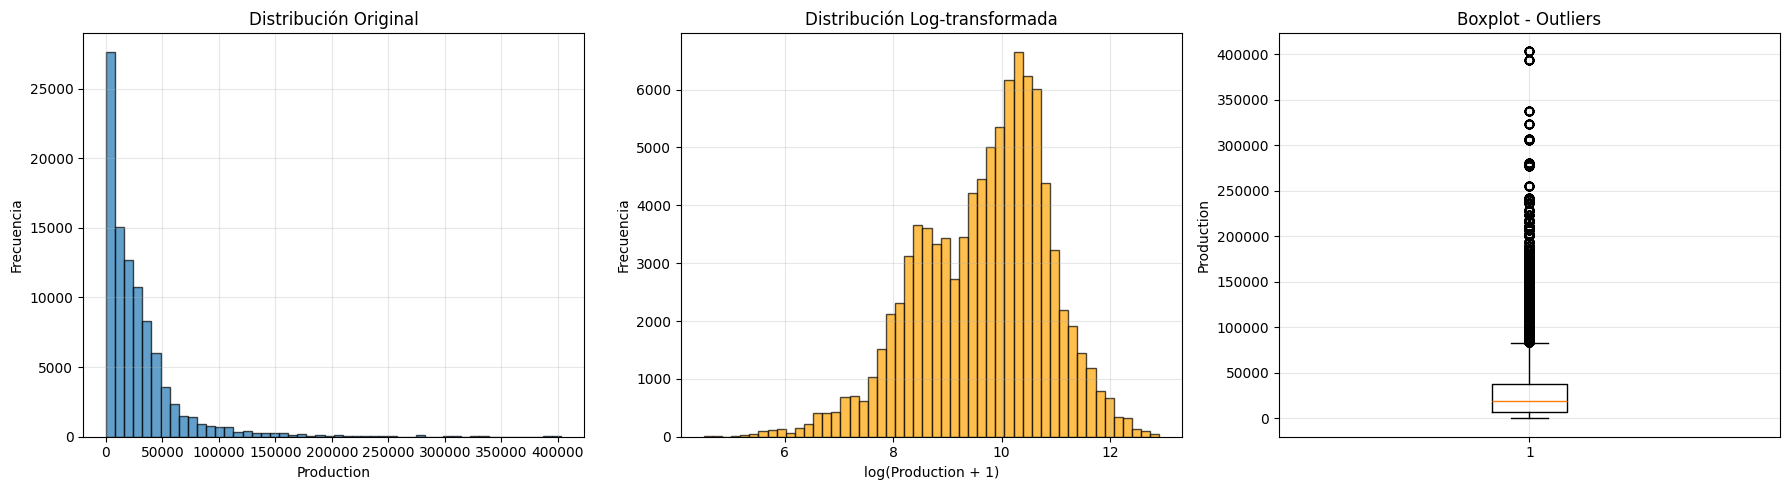


📊 Estadísticas de Production:
count     95339.000000
mean      28927.421055
std       34792.567183
min          90.000000
25%        6800.000000
50%       19266.000000
75%       37426.000000
max      403172.000000
Name: Production, dtype: float64


In [8]:
# Distribución del target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original
axes[0].hist(train_clean['Production'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Production')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución Original')
axes[0].grid(alpha=0.3)

# Log-transform
axes[1].hist(np.log1p(train_clean['Production']), bins=50, edgecolor='black', color='orange', alpha=0.7)
axes[1].set_xlabel('log(Production + 1)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución Log-transformada')
axes[1].grid(alpha=0.3)

# Boxplot
axes[2].boxplot(train_clean['Production'], vert=True)
axes[2].set_ylabel('Production')
axes[2].set_title('Boxplot - Outliers')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Estadísticas de Production:")
print(train_clean['Production'].describe())

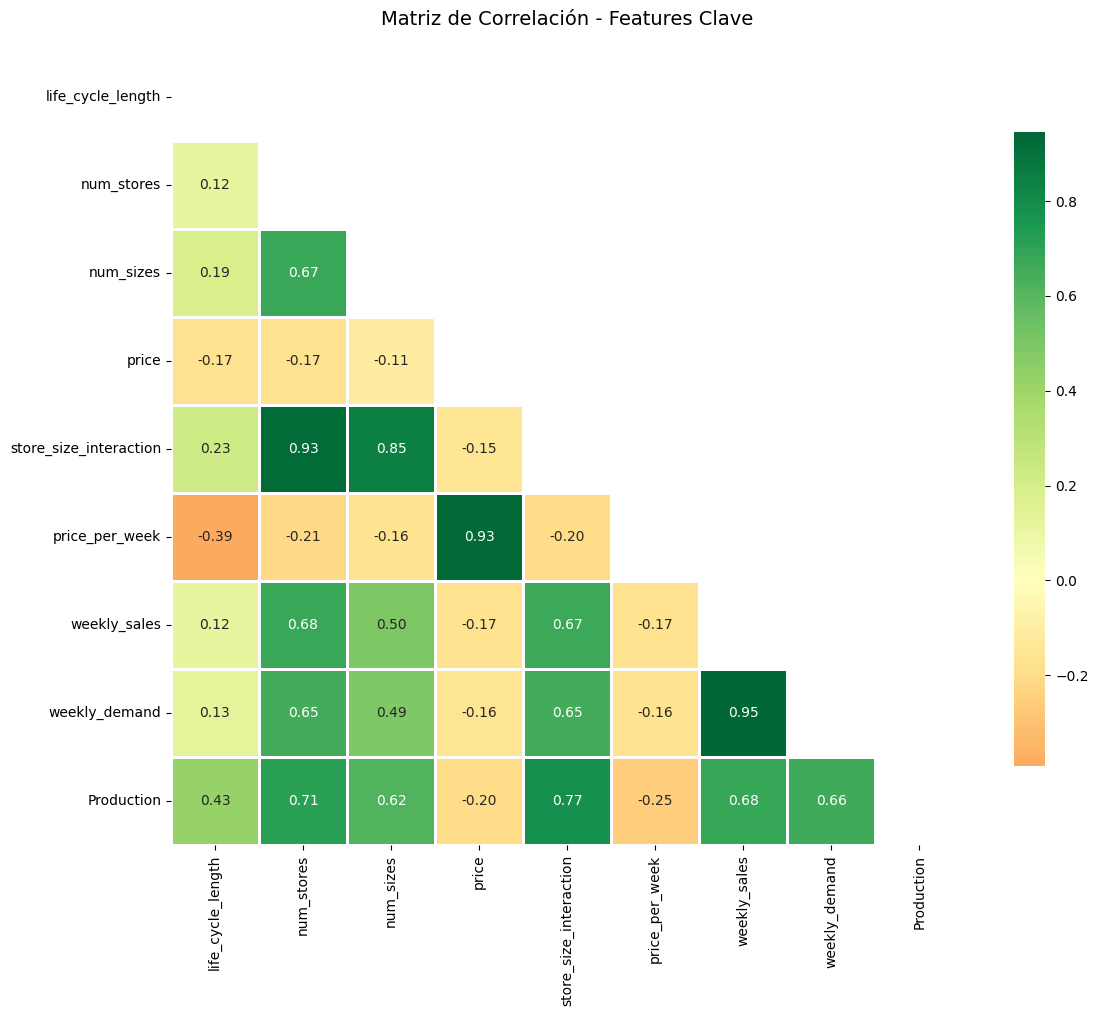


🔥 Top 10 correlaciones con Production:
total_capacity            0.872884
store_size_interaction    0.773440
num_stores                0.712734
weekly_sales              0.682236
weekly_demand             0.661472
num_sizes                 0.615199
stores_per_size           0.513157
sales_velocity            0.438299
life_cycle_length         0.427749
has_plus_sizes            0.342407
Name: Production, dtype: float64
total_capacity            0.872884
store_size_interaction    0.773440
num_stores                0.712734
weekly_sales              0.682236
weekly_demand             0.661472
num_sizes                 0.615199
stores_per_size           0.513157
sales_velocity            0.438299
life_cycle_length         0.427749
has_plus_sizes            0.342407
Name: Production, dtype: float64


In [18]:
# Correlaciones clave
key_cols = ['life_cycle_length', 'num_stores', 'num_sizes', 'price', 
            'store_size_interaction', 'price_per_week', 'Production']

if 'weekly_sales' in train_clean.columns:
    key_cols.insert(-1, 'weekly_sales')
if 'weekly_demand' in train_clean.columns:
    key_cols.insert(-1, 'weekly_demand')

plt.figure(figsize=(12, 10))
corr_matrix = train_clean[key_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Features Clave', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\n🔥 Top 10 correlaciones con Production:")
# Calcular correlación solo con columnas numéricas
numeric_df = train_clean.select_dtypes(include=[np.number])
prod_corr = numeric_df.corr()['Production'].sort_values(ascending=False)
print(prod_corr[1:11])

In [11]:
# Análisis por familia de producto
family_stats = train_clean.groupby('aggregated_family').agg({
    'Production': ['mean', 'median', 'std', 'count'],
    'price': 'mean',
    'num_stores': 'mean'
}).round(2)

family_stats.columns = ['_'.join(col).strip() for col in family_stats.columns.values]
family_stats = family_stats.sort_values('Production_mean', ascending=False)

print("\n📊 Estadísticas por Familia de Producto:")
print(family_stats)


📊 Estadísticas por Familia de Producto:
                        Production_mean  Production_median  Production_std  \
aggregated_family                                                            
Jeans                          59421.55            51571.0        46695.80   
T-shirts                       46916.22            30267.0        56205.61   
Trousers & leggings            30002.89            19656.0        37261.78   
Sweaters and Cardigans         29876.56            23981.0        25429.81   
Shirts                         29127.04            20606.0        36652.93   
Tops                           28808.23            20168.0        33602.48   
Jackets and Blazers            27919.63            19705.0        28220.02   
Skirts and shorts              22711.01            15100.0        23285.89   
Coats and Parkas               21348.18            14272.0        19315.87   
Dresses and jumpsuits          19361.62            13859.0        17799.79   
Swim and intimate      

## 💾 6. Guardar Dataset Limpio

In [12]:
# Guardar train limpio
train_clean.to_csv('train_cleaned.csv', index=False)
print("✅ Dataset de entrenamiento guardado: 'train_cleaned.csv'")
print(f"   📊 Shape: {train_clean.shape}")
print(f"   💾 Tamaño: {train_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Dataset de entrenamiento guardado: 'train_cleaned.csv'
   📊 Shape: (95339, 563)
   💾 Tamaño: 476.35 MB


## 📋 7. Limpiar Test Set

In [ ]:
# Limpiar test set con misma estrategia
test_clean = clean_dataset(test_df, is_train=False)
test_clean.to_csv('test_cleaned.csv', index=False)

print("\n✅ Dataset de test guardado: 'test_cleaned.csv'")
print(f"   📊 Shape: {test_clean.shape}")
print(f"   💾 Tamaño: {test_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

## 📝 8. Resumen Final y Próximos Pasos

In [ ]:
print("\n" + "="*80)
print("🎯 RESUMEN FINAL - LIMPIEZA CON MEJORES PRÁCTICAS")
print("="*80)

print(f"\n📦 DATASETS LIMPIOS:")
print(f"   Train: {train_df.shape} → {train_clean.shape}")
print(f"   Test:  {test_df.shape} → {test_clean.shape}")
print(f"   Columnas añadidas: +{train_clean.shape[1] - train_df.shape[1]}")

print(f"\n✨ MEJORAS APLICADAS:")
print("   ✓ Imputación contextual basada en familia de producto")
print("   ✓ 'Not Applicable' para atributos irrelevantes")
print("   ✓ Features temporales avanzadas (quarter, season)")
print("   ✓ Features derivadas de color (brightness, saturation)")
print("   ✓ Features de interacción (store×size, price/week)")
print("   ✓ Embeddings de imagen expandidos (512 dimensiones)")

print(f"\n📋 COLUMNAS CATEGÓRICAS PARA ENCODING:")
cat_cols = train_clean.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    n_unique = train_clean[col].nunique()
    print(f"   - {col}: {n_unique} valores únicos")

print(f"\n🚀 PRÓXIMOS PASOS:")
print("   1️⃣  Label Encoding para variables categóricas")
print("   2️⃣  Feature Selection (analizar importancia de embeddings)")
print("   3️⃣  Split train/validation estratificado por season")
print("   4️⃣  Entrenar LightGBM/XGBoost con CV")
print("   5️⃣  Hyperparameter tuning con Optuna")
print("   6️⃣  Stacking/Ensembling de modelos")

print("\n" + "="*80)
print("✅ ¡DATASET LISTO PARA MODELADO CON GRADIENT BOOSTING!")
print("="*80)

---

## 💡 Notas Importantes:

### Ventajas de esta estrategia:

1. **Imputación Contextual**: No rellenamos todo con "Unknown", sino que usamos el contexto (familia de producto, tipo de fabric) para imputar valores lógicos

2. **"Not Applicable"**: Distinguimos entre "no tenemos el dato" vs "este atributo no aplica", lo cual es información valiosa para el modelo

3. **Features de Interacción**: Capturan relaciones no lineales que GBM puede explotar

4. **Features Temporales**: Season indicators ayudan a capturar patrones estacionales

5. **Color Features**: Brightness y saturation pueden correlacionar con demanda (colores claros en verano, oscuros en invierno)

### Para LightGBM/XGBoost:
- Usar `categorical_feature` parameter para las columnas categóricas
- Considerar `objective='regression'` o `objective='quantile'` según la métrica
- Los embeddings pueden ser muy poderosos pero requieren regularización

### Consideraciones:
- Los 512 embeddings pueden causar overfitting → considerar PCA o feature selection
- El target puede beneficiarse de log-transform
- Validación temporal (seasons anteriores → predecir season futura)